D:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)
D:\Anaconda3\lib\site-packages\pandas\computation\expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))
D:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


       客户群1      客户群2      客户群3      客户群4      客户群5
0  0.050179 -0.701171  0.483583 -0.314330  1.159808
1 -0.007519 -0.414414 -0.786690  1.695974 -0.376560
2 -0.230002 -0.161572  2.482942 -0.574257 -0.088288
3 -0.234200 -0.161194  2.423437 -0.536969 -0.096046
4  2.182633 -0.256520  0.310153 -0.171768 -0.157308


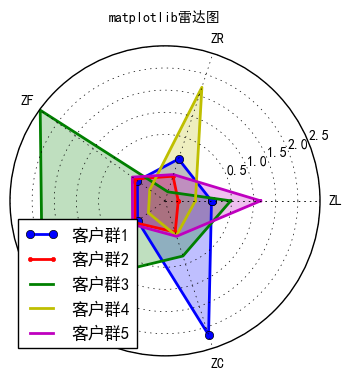

   聚类类别   聚类个数        ZL        ZR        ZF        ZM        ZC
0  客户群1   4216  0.050179 -0.007519 -0.230002 -0.234200  2.182633
1  客户群2  24687 -0.701171 -0.414414 -0.161572 -0.161194 -0.256520
2  客户群3   5339  0.483583 -0.786690  2.482942  2.423437  0.310153
3  客户群4  12029 -0.314330  1.695974 -0.574257 -0.536969 -0.171768
4  客户群5  15773  1.159808 -0.376560 -0.088288 -0.096046 -0.157308


In [5]:
#coding=utf-8
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import preprocessing 
from sklearn.cluster import KMeans
%matplotlib inline
#导入数据
data=pd.read_excel('C:\\Users\\hp\\Desktop\\data_HK.xlsx')

#数据的基本探索
explore=data.describe().T
explore['null']=len(data)-explore['count']
explore=explore[['null','max','min']]
explore.columns=['空值数','最大值','最小值']

#数据清洗:删除票价为空值的记录
data=data[data['EXPENSE_SUM_YR_1'].notnull()*data['EXPENSE_SUM_YR_2'].notnull()]
#删除票价为0，平均折扣率不为0，总飞行公里数大于0的记录
df1=data['EXPENSE_SUM_YR_1']!=0
df2=data['EXPENSE_SUM_YR_2']!=0
df3=(data['SEG_KM_SUM']==0)&(data['avg_discount']==0)
data=data[df1|df2|df3]

#属性规约：选取与LRFMC模型相关的变量
data=data[['MEMBER_NO','L','R','FLIGHT_COUNT','SEG_KM_SUM','avg_discount']]

#数据变换：属性构造和数据标准化
data['F']=data['FLIGHT_COUNT']
data['M']=data['SEG_KM_SUM']
data['C']=data['avg_discount']
data=data[['MEMBER_NO','L','R','F','M','C']]

#Z-Score标准化
zscore = preprocessing.StandardScaler()
# 标准化处理
data_zs= pd.DataFrame(zscore.fit_transform(data[['L','R','F','M','C']]))
data_zs.columns=[i for i in ['ZL','ZR','ZF','ZM','ZC']]

#模型构建
model=KMeans(n_clusters=5,n_jobs=4)
model.fit(data_zs)
model.cluster_centers_
model.labels_
c1 = pd.Series(model.labels_) 
c1=c1.value_counts()
c2=pd.DataFrame(model.cluster_centers_)
c3=pd.Series(['客户群1','客户群2','客户群3','客户群4','客户群5',])
c=pd.concat([c3,c1,c2],axis=1) 
c.columns=['聚类类别','聚类个数']+list(data_zs.columns) #列名命名

#绘制雷达图
labels = np.array(list(data_zs.columns))#标签
dataLenth = 5#数据个数
y0=c2.T
y0.columns=list(c3)
print(y0)
fig = plt.figure()
y=[]
for x in list(c3):
    dt= y0[x]
    dt=np.concatenate((dt,[dt[0]]))
    y.append(dt)
ax = fig.add_subplot(111, polar=True)
angles = np.linspace(0, 2*np.pi, dataLenth, endpoint=False) 
angles = np.concatenate((angles, [angles[0]]))
ax.plot(angles, y[0], 'bo-', linewidth=2)
ax.plot(angles, y[1], 'r.-', linewidth=2)
ax.plot(angles, y[2], 'g-', linewidth=2)
ax.plot(angles, y[3], 'y-', linewidth=2)
ax.plot(angles, y[4], 'm-', linewidth=2)
plt.rcParams['font.sans-serif']=['SimHei'] 

ax.legend(c3,loc=3)
ax.fill(angles,y[0], facecolor='b', alpha=0.25)   # 填充
ax.fill(angles,y[1], facecolor='r', alpha=0.25) 
ax.fill(angles,y[2], facecolor='g', alpha=0.25) 
ax.fill(angles,y[3], facecolor='y', alpha=0.25) 
ax.fill(angles,y[4], facecolor='m', alpha=0.25) 
ax.set_thetagrids(angles * 180/np.pi, labels, fontproperties="SimHei")
ax.set_title("matplotlib雷达图", va='bottom', fontproperties="SimHei")
ax.set_rlim(-1,2.5)
ax.grid(True)
plt.show()
print(c)


'''扩展：若要预测类别，可利用pipeline处理简化运算,无需再记录训练时标准化的参数
from sklearn.pipeline import make_pipeline
my_pipeline = make_pipeline(preprocessing.StandardScaler(),KMeans() )
my_pipeline.fit(train_x)
predictions = my_pipeline.predict(test_x)
'''

In [8]:
#扩展：若要预测类别，可利用pipeline处理简化运算
from sklearn.pipeline import make_pipeline
my_pipeline = make_pipeline(preprocessing.StandardScaler(),KMeans() )
my_pipeline.fit(train_x)
predictions = my_pipeline.predict(test_x)


D:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


TypeError: 'type' object is not subscriptable

In [9]:
print(pd.DataFrame(c))

   聚类类别   聚类个数        ZL        ZR        ZF        ZM        ZC
0  客户群1   4216  0.050179 -0.007519 -0.230002 -0.234200  2.182633
1  客户群2  24687 -0.701171 -0.414414 -0.161572 -0.161194 -0.256520
2  客户群3   5339  0.483583 -0.786690  2.482942  2.423437  0.310153
3  客户群4  12029 -0.314330  1.695974 -0.574257 -0.536969 -0.171768
4  客户群5  15773  1.159808 -0.376560 -0.088288 -0.096046 -0.157308
